In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
sys.path.append('/Users/mamba/Documents') #TODO: replace with direct import
import Code.pertpy.pertpy as pt

In [4]:
#import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
blm_pbs_associations = pd.read_csv("dialogue_output/day 10/blm_pbs_associations.csv", index_col=0)
blm_nintedanib_associations = pd.read_csv("dialogue_output/day 10/blm_nintedanib_associations.csv", index_col=0)
blm_GLPG1690_associations = pd.read_csv("dialogue_output/day 10/blm_GLPG1690_associations.csv", index_col=0)
blm_GLPG1205_associations = pd.read_csv("dialogue_output/day 10/blm_GLPG1205_associations.csv", index_col=0)
blm_combo_associations = pd.read_csv("dialogue_output/day 10/blm_combo_associations.csv", index_col=0)

association_dfs = [blm_pbs_associations, blm_nintedanib_associations, blm_GLPG1690_associations, blm_GLPG1205_associations, blm_combo_associations]

In [6]:
def plot_heatmap(associations_df, vmax=None, create_fig=True, cbar=True, cmap="viridis"):
    log_associations_df = associations_df.copy()
    for mcp_nr in range(6):
        log_associations_df[f"MCP {mcp_nr + 1}"] = -1 * np.log10(log_associations_df[f"mcp_{mcp_nr}"])
    log_associations_df = log_associations_df.drop(columns=[f"mcp_{mcp_nr}" for mcp_nr in range(6)])
    
    if create_fig:
        plt.figure(figsize=(2.2, 6))
    if cbar:
        sns.heatmap(log_associations_df, vmin=0, vmax=vmax, cbar=True, cmap=cmap)
    else:
        sns.heatmap(log_associations_df, vmin=0, vmax=vmax, cbar=False, cmap=cmap)

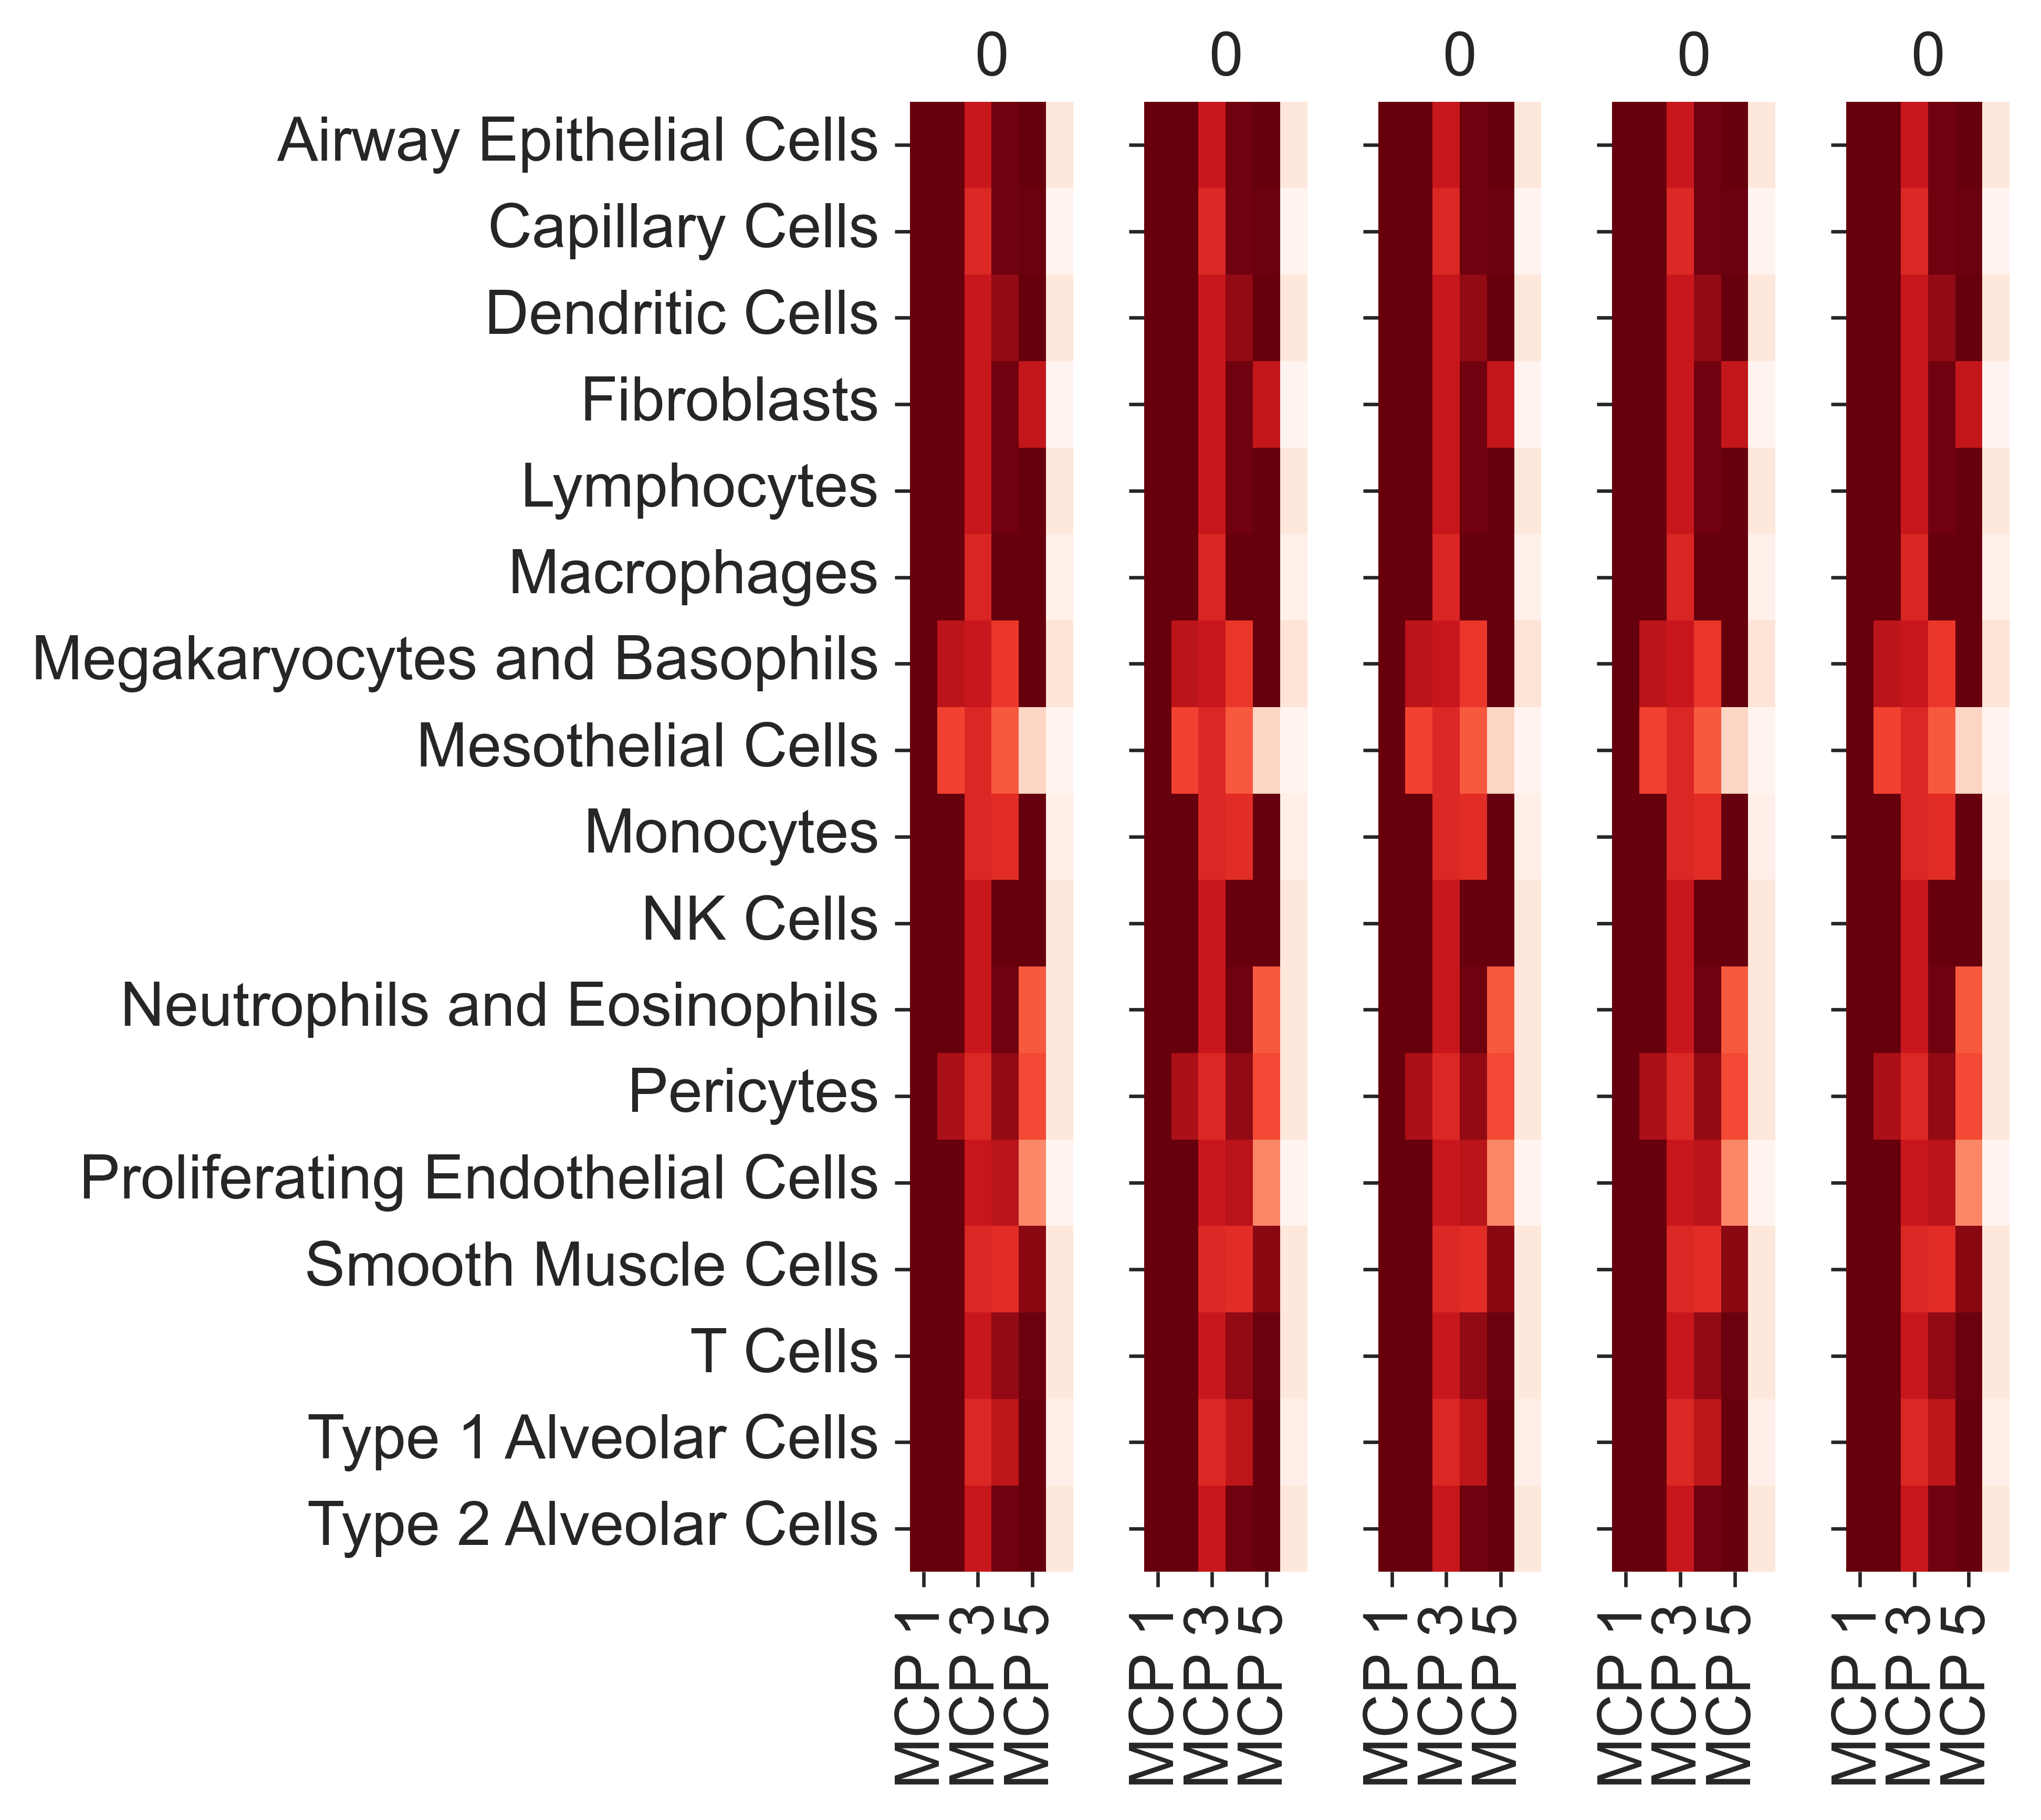

In [7]:
# Plot all three in one plot with subplots, take the global max as vmax
global_max = (-1 * np.log10([df.max() for df in association_dfs])).max()

plt.subplots(1, len(association_dfs), figsize=(6.7, 6), sharey=True)
for i, associations_df in enumerate(association_dfs):
    plt.subplot(1, len(association_dfs), i + 1)
    plot_heatmap(associations_df, vmax=global_max, create_fig=False, cbar=False, cmap="Reds")
    plt.title(associations_df.columns[0].split("_")[1])

plt.tight_layout()
plt.savefig("figures/heatmap_mcp_associations.pdf")
plt.show()